In [2]:
# some basic setup
# inspired by https://www.youtube.com/watch?v=Oieh4YFZZz0
# https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_network_sine_learning/nn_learns_sine_function_with_autodiff_in_jax.ipynb

# goals
# - get more comfortable with how a neural network works internally
# - get exposure to JAX

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
N_SAMPLES = 200
LAYERS = [1, 20, 20, 20, 1]
LR = .1
N_EPOCHS = 30000
LEARNING_RATE = .1

In [3]:
# create dataset randomly
# random numbers in Jax need to be created differently
# they are randomly generated but deterministic - every time you rerun this you get the same value
key = jax.random.PRNGKey(64)

In [4]:
key, xkey, ynoisekey = jax.random.split(key, 3)  # splits the original key into 3 parts 
                                                 # seems to just be rng with `key` as a seed?
x_samples = jax.random.uniform(xkey,  # draw randomly from a uniform distribution
                               (N_SAMPLES, 1),  # get a data matrix of shape (N_SAMPLES, 1)
                               minval=0.0, maxval=2 * jnp.pi)
# create a target variable that's sin(x)
y_samples = jnp.sin(x_samples) + \
    jax.random.normal(ynoisekey,  # add random noise to it
                      (N_SAMPLES, 1)) * 0.3  # add a different amount of random noise to each value
                                             # multiply by roughly the sd of the normal dist 
                                             # you're drawing from (?)

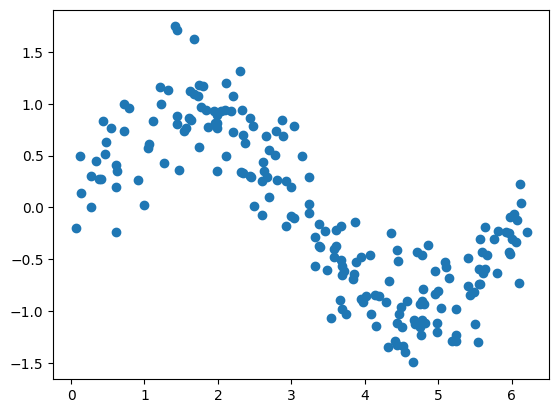

In [5]:
plt.scatter(x_samples, y_samples)
plt.show()

In [6]:
# weight initialization
weight_matrices = []  # 4 entries in each bc we have 4 layer transitions 
                      # (5 layers, 4 sets of connections)
bias_vectors = []
activation_functions = []

for (fan_in, fan_out) in zip(LAYERS[:-1], LAYERS[1:]):  # fan in = input dimension, fan out = hidden dimension
    kernel_matrix_uniform_limit = jnp.sqrt(6 /  # this 6 is from the Xavier Glorot Uniform init formula
                                           (fan_in + fan_out))

    key, wkey = jax.random.split(key)
    W = jax.random.uniform(wkey,  # draw from uniform distribution w xavier glorot uniform init
                           (fan_in, fan_out),
                           minval=-kernel_matrix_uniform_limit,
                           maxval=+kernel_matrix_uniform_limit,
                           )
    b = jnp.zeros(fan_out)

    # append all these things to their respective lists
    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(jax.nn.sigmoid)

activation_functions[-1] = lambda x: x  # we don't want a sigmoid here, just the value itself

In [7]:
def network_forward(x, weights, biases, activations):
    a = x  # a denotes the activated state in each layer
    for W, b, f in zip(
        weights, 
        biases,
        activations,
    ):
        a = f(a @ W + b)  # inputs = activation_func of inputs times weight matrix + biases
    return a

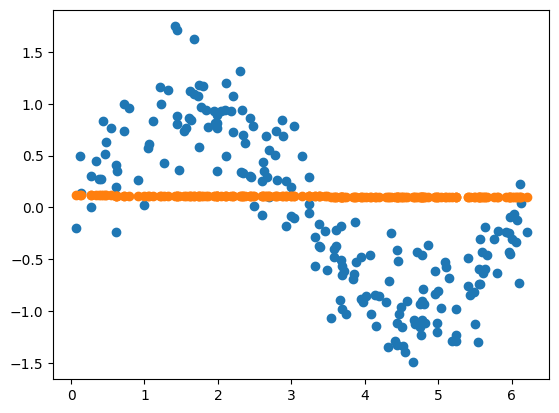

In [8]:
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))
plt.show()

In [9]:
def loss_forward(y_guess, y_ref):
    # this is the loss function the guy in the tutorial used
    # like a modified RMSE basically
    delta = y_guess - y_ref
    return .5 * jnp.mean(delta**2)

In [10]:
# test what we just made to make sure it works!
loss_forward(
    network_forward(x_samples, weight_matrices, bias_vectors, activation_functions),
    y_samples
)

Array(0.30838406, dtype=float32)

In [11]:
# next we have to find the gradients of the error wrt the weights and biases
# jax.grad takes derivative, but we need the forward evaluation too, which this will perform
# this will get us our loss function value also 
# take derivative of network forward and loss forward
loss_and_grad_fun = jax.value_and_grad(
    lambda Ws, bs: loss_forward(
        network_forward(
            x_samples,
            Ws,  # argnum 0
            bs,  # argnum 1
            activation_functions,
        ),
        y_samples
    ),
    argnums=(0, 1)  # get derivative wrt weights & biases
                    # argnums specifies which arguments of lambda to take the derivative wrt
                    # also note that the lambda only takes *weights/biases* as arguments but uses
                    # x_samples and activation functions within the code - this means it uses the
                    # global (?) values there 
)

In [12]:
initial_loss, (initial_weight_gradient, initial_bias_gradient) = loss_and_grad_fun(
    weight_matrices, 
    bias_vectors
)

In [13]:
initial_loss  # value should be the same as when we just ran the loss function up above

Array(0.30838406, dtype=float32)

In [14]:
# slow without specifying the just-in-time compilation
# JIT analyzes function to try to just-in-time compile it
loss_and_grad_fun = jax.jit(loss_and_grad_fun)

In [15]:
# Training loop
loss_history = []
for epoch in range(N_EPOCHS):
    loss, (weight_gradients, bias_gradients) = loss_and_grad_fun(
        weight_matrices, 
        bias_vectors,
    )

    weight_matrices = jax.tree_map(  # can't update matrices in place so we have to do this 
                                     # tree_map uses pytrees (?) to apply the function to the two
                                     # lists of arrays
        lambda W, W_grad: W - LEARNING_RATE * W_grad,
        weight_matrices,
        weight_gradients
    )

    bias_vectors = jax.tree_map(  # can't update matrices in place so we have to do this 
                                     # tree_map uses pytrees (?) to apply the function to the two
                                     # lists of arrays
        lambda b, b_grad: b - LEARNING_RATE * b_grad,
        bias_vectors,
        bias_gradients,
    )

    if epoch % 100 == 0:
        print(f'epoch: {epoch}, loss: {loss}')

    loss_history.append(loss)


/var/folders/51/6b4306h90693z7j7cd0g40kr0000gn/T/ipykernel_19262/2251717779.py:9: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  weight_matrices = jax.tree_map(  # can't update matrices in place so we have to do this
/var/folders/51/6b4306h90693z7j7cd0g40kr0000gn/T/ipykernel_19262/2251717779.py:17: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  bias_vectors = jax.tree_map(  # can't update matrices in place so we have to do this


epoch: 0, loss: 0.3083840608596802
epoch: 100, loss: 0.2834208607673645
epoch: 200, loss: 0.2731638252735138
epoch: 300, loss: 0.256268173456192
epoch: 400, loss: 0.2275221347808838
epoch: 500, loss: 0.18609967827796936
epoch: 600, loss: 0.15082566440105438
epoch: 700, loss: 0.13715413212776184
epoch: 800, loss: 0.13339465856552124
epoch: 900, loss: 0.1318383812904358
epoch: 1000, loss: 0.13095350563526154
epoch: 1100, loss: 0.13036641478538513
epoch: 1200, loss: 0.129926398396492
epoch: 1300, loss: 0.12956157326698303
epoch: 1400, loss: 0.1292349100112915
epoch: 1500, loss: 0.12892605364322662
epoch: 1600, loss: 0.12862320244312286
epoch: 1700, loss: 0.1283191293478012
epoch: 1800, loss: 0.12800917029380798
epoch: 1900, loss: 0.12769004702568054
epoch: 2000, loss: 0.1273593157529831
epoch: 2100, loss: 0.12701493501663208
epoch: 2200, loss: 0.12665511667728424
epoch: 2300, loss: 0.12627814710140228
epoch: 2400, loss: 0.12588238716125488
epoch: 2500, loss: 0.12546610832214355
epoch: 260

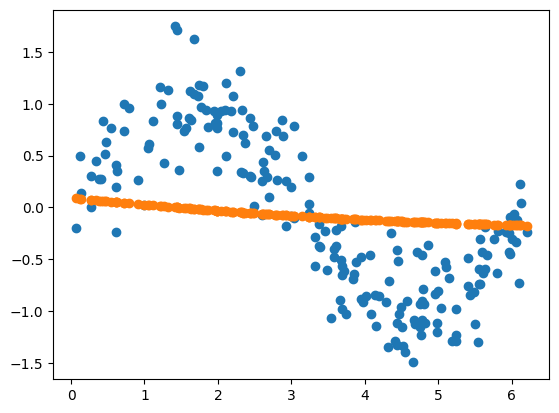

In [34]:
# first run: tried with lr = 0.001 and was way too small - it didn't converge!
# plt.scatter(x_samples, y_samples)
# plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))

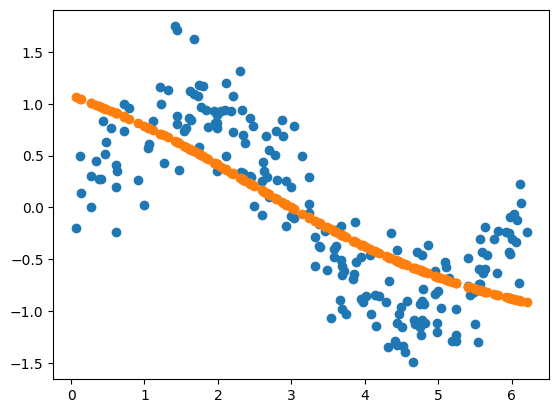

In [16]:
# second run: tried with lr = 0.01 and was still too small - it didn't converge!
# looks better than the first run though :)
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))

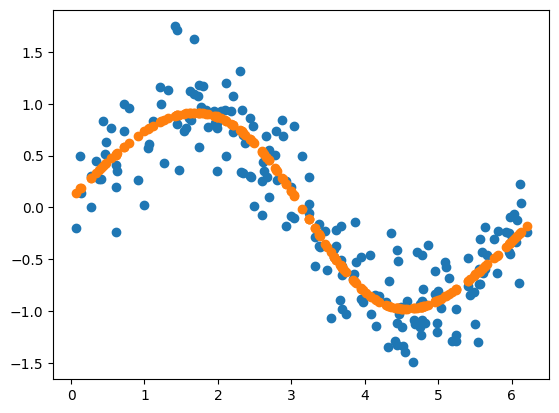

In [16]:
# third run: tried with lr = 0.1 (like the demo has) - it looks great!!
plt.scatter(x_samples, y_samples)
plt.scatter(x_samples, network_forward(x_samples, weight_matrices, bias_vectors, activation_functions))